Rep Counter Code translated on-device

In [ ]:
import numpy as np
import pylab

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    signals2 = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    count = 0;
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1] and y[i] > 500:
                signals[i] = 1
                if (1 not in signals[i-200:i]):
                    count += 1
                    signals2[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(
                count = count,
                signals = np.asarray(signals),
                signals2 = np.asarray(signals2),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [ ]:
with open('sample.txt') as f:
  raw = f.readlines()
  raw = [x[16:-1].split(" ") for x in raw]
  average = [(int(x[0]) + int(x[1]) + int(x[2])) / 3 for x in raw]

  algo_data = thresholding_algo(average, 500, 2, 0.8)['signals']
  algo_avg = thresholding_algo(average, 500, 2, 0.8)['avgFilter']
  algo_std = thresholding_algo(average, 500, 2, 0.8)['stdFilter']
  algo_data2 = thresholding_algo(average, 500, 2, 0.8)['signals2']

  count = thresholding_algo(average, 50, 2, 0.5)['count']


11


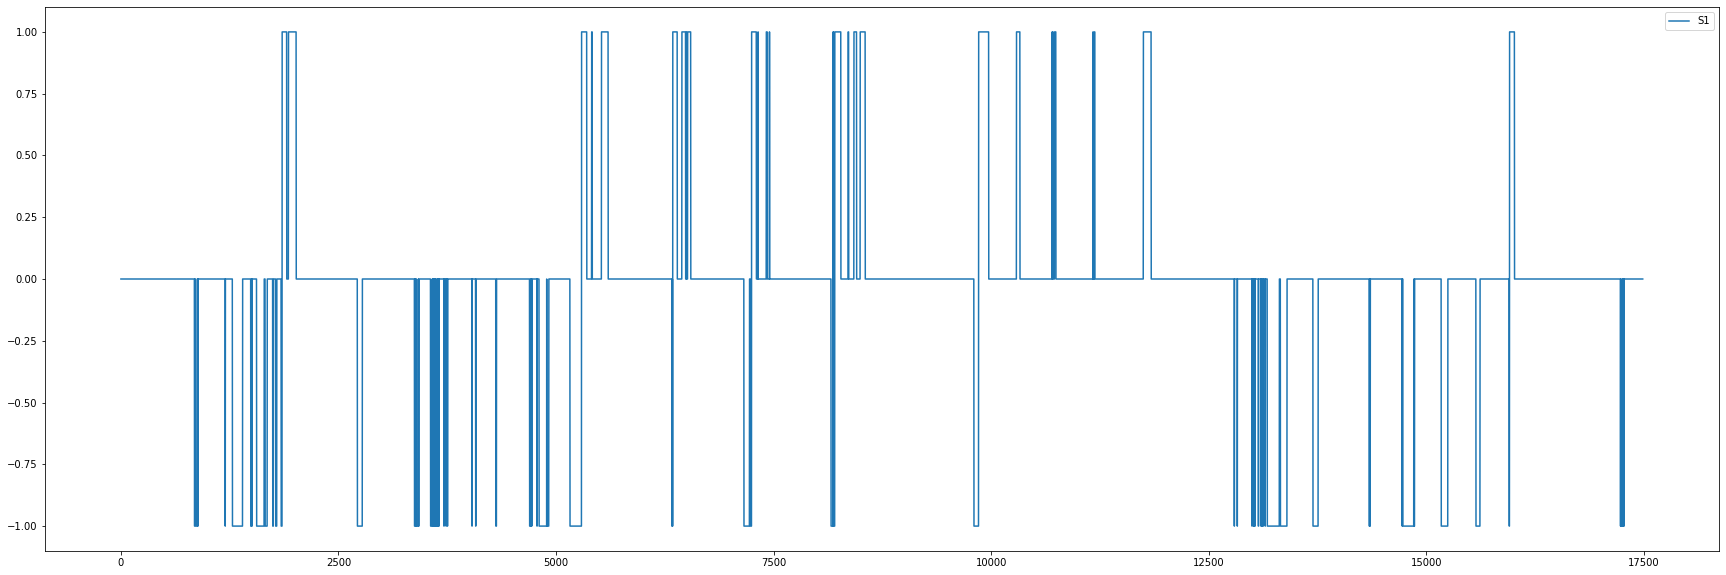

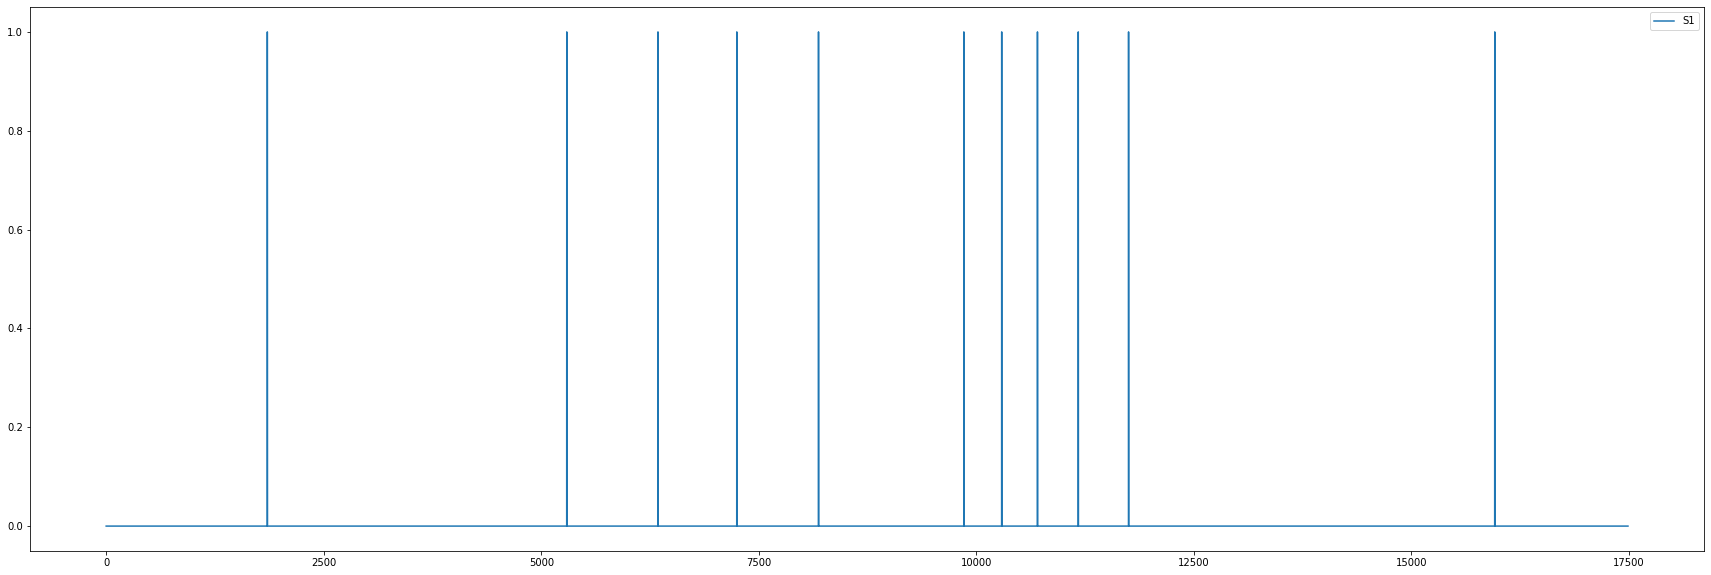

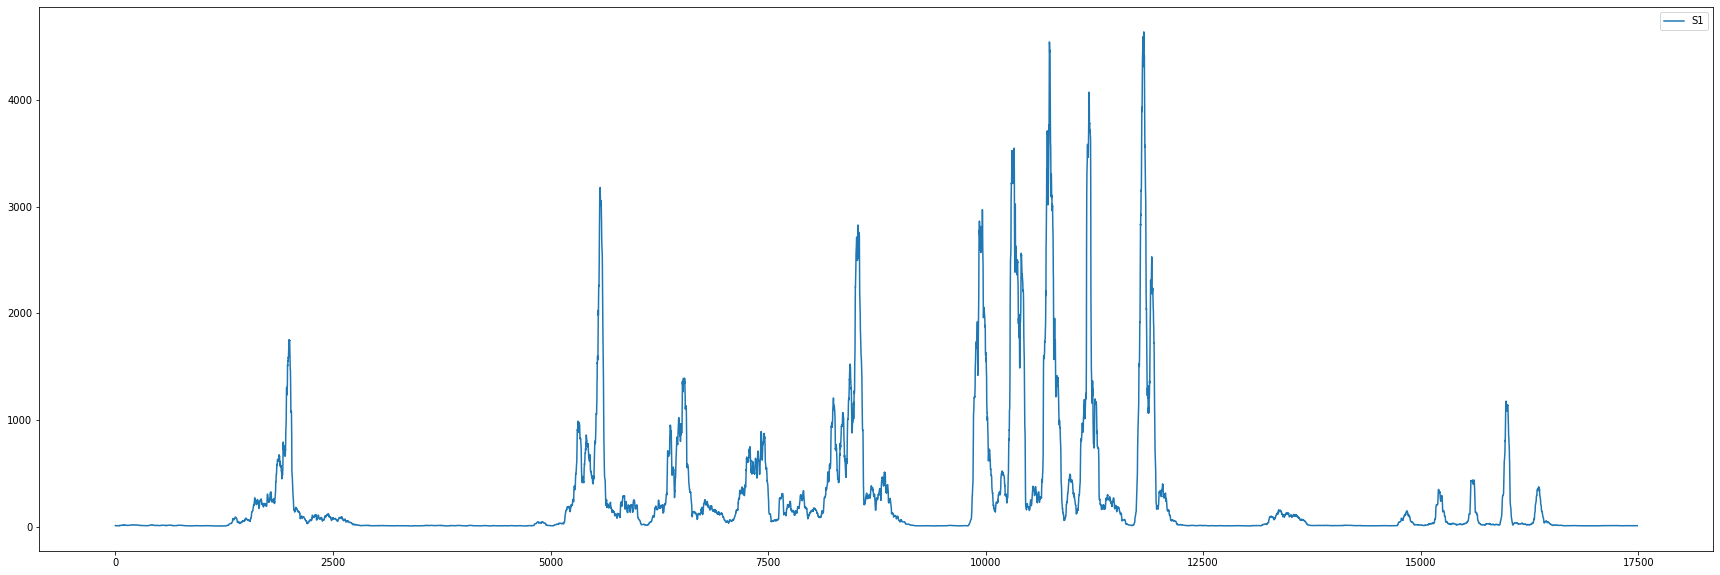

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(algo_data, columns=['S1'])
df.plot(figsize=(30, 10))

df = pd.DataFrame(algo_data2, columns=['S1'])
df.plot(figsize=(30, 10))

# df = pd.DataFrame(algo_avg, columns=['S1'])
# df.plot(figsize=(30, 10))

# df = pd.DataFrame(algo_std, columns=['S1'])
# df.plot(figsize=(30, 10))

df = pd.DataFrame(average, columns=['S1'])
df.plot(figsize=(30, 10))

print(count)

Attempted RNN LTSM model for rep counter

layers=[8, 8, 8, 1], train_examples=5, test_examples=5
batch = 5, timesteps = 5, features = 3, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 8)              384       
                                                                 
 batch_normalization_30 (Bat  (None, 5, 8)             32        
 chNormalization)                                                
                                                                 
 lstm_31 (LSTM)              (None, 5, 8)              544       
                                                                 
 batch_normalization_31 (Bat  (None, 5, 8)             32        
 chNormalization)                                                
                                                                 
 lstm_32 (LSTM) 

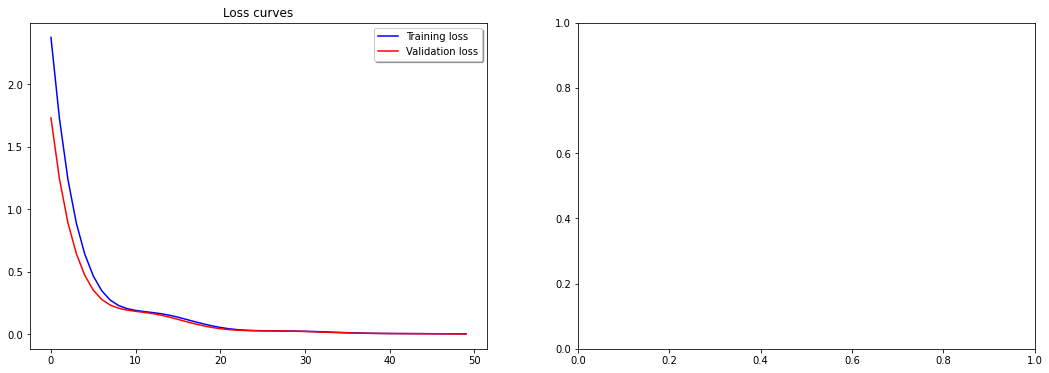

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

# Dummy data (sadly I did not have enough time to spend on parsing data)
X_train = np.zeros((5, 5, 3))
y_train = np.zeros((5, 1))
X_test = np.zeros((5, 5, 3))
y_test = np.zeros((5, 1))
T = 5
N = 3

LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 50                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_test[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,verbose=0,
                    callbacks=[lr_decay])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
# axs[1] plot accuracy
plt.show()